### Testing PSD slope for E:I balance

In [1]:
import os as os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [60]:
def PSD_slope(site, psd, frqs, band, min_samples):
    '''Function to fit a linear regression over the region of the PSD specified by band.\n
    Two models are fitted: simple linear regression and RANSAC (robust) regression.\n
    Residuals of both models are compared with R squared and the best fit is kept.\n
    psd (pandas.Series) Relative power for each frecuency\n
    frqs (pandas.Series) Frecuency in Hz for each power datum.\n
    band (tupple) Limits for the band of interest.\n
    min_samples (int) Minimal number of samples to keep in the robust regression.
    '''
    
    mask = np.logical_and(frqs>= band[0], frqs<= band[1])
    X_fit = np.reshape(np.log10(frqs[mask].values), (-1,1))
    Y_fit = np.reshape(np.log10(psd[mask].values), (-1,1))
    
    # Fit ordinary linear regression
    lr = linear_model.LinearRegression()
    lr.fit(X_fit, Y_fit)
    
    lr_p = lr.predict(X_fit)
    # R^2 Score
    lr_score = r2_score(Y_fit, lr_p)
    
    # Fit RANSAC
    rm = linear_model.RANSACRegressor(min_samples = min_samples, max_trials = 500)
    rm.fit(X_fit, Y_fit)
    
    rm_p =rm.predict(X_fit)
    rm_score = r2_score(Y_fit[rm.inlier_mask_], rm_p[rm.inlier_mask_])
    
    if lr_score > rm_score:
        print('Best fit: Ordinary Linear Regression')
        print(f'intercept: {lr.intercept_} \nslope {lr.coef_}')
        model = 'LinReg'
        best_fit = lr_p
        slope = lr.coef_
        intercept = lr.intercept_
        r_sq = lr_score
        print(f'R^2= {r_sq}\nVS\n{rm_score}')
    else:
        print('Best fit: RANSAC Regression')
        print(f'intercept: {rm.estimator_.intercept_} \nslope {rm.estimator_.coef_}')
        model = 'RANSAC'
        best_fit = rm_p
        slope = rm.estimator_.coef_
        intercept = rm.estimator_.intercept_
        r_sq = rm_score
        print(f'R^2= {r_sq}\nVS\n{lr_score}')
        
    fig = plt.figure(figsize=(6, 3))
    plt.subplot(121)
    plt.plot(np.log10(frqs), np.log10(psd), linewidth = 0.5)
    plt.plot(np.log10(frqs[mask]), np.log10(psd[mask]), 'r--', linewidth = 0.7)
    plt.title(site)
    plt.ylabel('Rel. Power (dB)')
    plt.xlabel('Fq. log(Hz)')
    plt.subplot(122)
    plt.plot(np.log10(frqs[mask]), np.log10(psd[mask]), linewidth = 0.5)
    plt.plot(np.log10(frqs[mask]), best_fit, 'r--')
    plt.ylabel('Rel. Power (dB)')
    plt.xlabel('Fq. log(Hz)')
    plt.tight_layout()
    #plt.show()
    
    return (slope, intercept, model, r_sq), fig

In [17]:
def meta(file_name):
     '''Get the meta data for each file: ID, Genotype, Sex, Tx'''
     meta_bits = file_name.split('_')
     ID = meta_bits[0]
     gen = meta_bits[1]
     tx = meta_bits[2]
     
     meta_tp = (ID, gen, tx)
     return meta_tp
     

In [21]:
def preprocess(file_name):
     '''Get the psd and frequency data'''
     
     file_df = pd.read_csv(psd_dir+'/'+file_name)
     fqrs = file_df['Frqs (Hz)'].copy()
     ca1_psd = file_df['CA1_psd'].copy()
     ca3_psd = file_df['CA3_psd'].copy()
     dg_psd = file_df['DG_psd'].copy()
     
     psd_data = (fqrs, ca1_psd, ca3_psd, dg_psd)
     return psd_data

In [100]:
def process_file(file_name, band = (1, 50), min_samples = 95):
     '''Run the complete process of a file.'''
     
     slope_dic = {'ID':[], 'Genotype':[], 'Tx':[], 'Site':[], 'Model':[], 'Slope':[], 'Intercept':[], 'R^2':[]}
     
     meta_data = meta(file_name) # get the meta data: gen, tx, sex
     psd_data = preprocess(file_name) # get the numeric data
     
     fqrs = psd_data[0]
     data_dic = {'CA1' : psd_data[1], 'CA3': psd_data[2], 'DG': psd_data[3]}
     
     
     for site, psd in data_dic.items():
     
          lin_regress, fig = PSD_slope(site = site, psd = psd, frqs = fqrs, band = band, min_samples = min_samples)
          
          slope_dic['ID'].append(meta_data[0])
          slope_dic['Genotype'].append(meta_data[1])
          slope_dic['Tx'].append(meta_data[2])
          slope_dic['Site'].append(site)
          slope_dic['Model'].append(lin_regress[2])
          slope_dic['Slope'].append(lin_regress[0])
          slope_dic['Intercept'].append(lin_regress[1])
          slope_dic['R^2'].append(lin_regress[3])
          
          
          sub = file_name.strip('.csv')
          #fig.savefig('/Users/labc02/Documents/PDCB_data/MK-project/LFP_data/Spectral_Long/slope_long_figs/' + 
                     #sub + '_' + f'{site}' + '.svg')
          plt.close(fig)
     
     slope_df = pd.DataFrame(slope_dic)
          
     return slope_df
     #fig.savefig(psd_dir+file_name+'_fig.svg')
     

In [2]:
psd_dir = '/Users/labc02/Documents/PDCB_data/MK-project/LFP_data/Spectral_Long'

In [8]:
psd_files = [file for file in os.listdir(psd_dir) if 'psd.csv' in file]

In [107]:
slopes_df = []

for file in psd_files:
     
     slope_df = process_file(file, band = (1, 50), min_samples = 95)
     slopes_df.append(slope_df)

Best fit: RANSAC Regression
intercept: [3.26887576] 
slope [[-1.64173844]]
R^2= 0.9788769837605977
VS
0.9751250189669711
Best fit: RANSAC Regression
intercept: [3.4867984] 
slope [[-1.27534488]]
R^2= 0.9557509431823353
VS
0.931446421418279
Best fit: RANSAC Regression
intercept: [3.45907007] 
slope [[-0.99402815]]
R^2= 0.9516366803718815
VS
0.898796137472156
Best fit: RANSAC Regression
intercept: [4.62090681] 
slope [[-2.0284959]]
R^2= 0.9601508344454799
VS
0.9589882045832623
Best fit: RANSAC Regression
intercept: [4.03680004] 
slope [[-1.64977482]]
R^2= 0.9555822209227567
VS
0.9066602596727052
Best fit: RANSAC Regression
intercept: [4.2861991] 
slope [[-1.46711417]]
R^2= 0.9610618752950961
VS
0.9087556335826732
Best fit: RANSAC Regression
intercept: [4.53209757] 
slope [[-2.24954286]]
R^2= 0.9645663892528326
VS
0.9635045850934
Best fit: RANSAC Regression
intercept: [4.94924658] 
slope [[-2.17643689]]
R^2= 0.9842432503572774
VS
0.9842432503572774
Best fit: RANSAC Regression
intercept: [

In [108]:
slps_df = pd.concat(slopes_df)

In [109]:
slps_df['Slope'] = slps_df['Slope'].astype(float)

In [87]:
import pingouin as pg

/opt/miniconda3/envs/dataAlpha/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


<AxesSubplot:xlabel='Site', ylabel='Slope'>

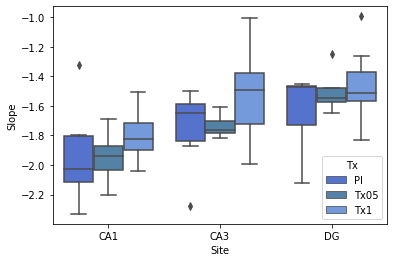

In [110]:
sns.boxplot(data = slps_df[slps_df['Genotype']== 'WT'], x = 'Site', y = 'Slope', hue = 'Tx', hue_order = ['Pl', 'Tx05', 'Tx1'], palette = ['royalblue', 'steelblue', 'cornflowerblue'])


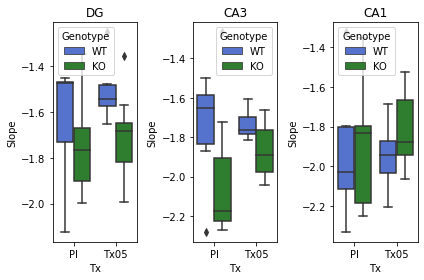

In [111]:
plt.subplot(131)
sns.boxplot(data = slps_df[(slps_df['Tx']!= 'Tx1') & (slps_df['Site'] == 'DG')], x = 'Tx', y = 'Slope', hue = 'Genotype', order = ['Pl', 'Tx05'], hue_order = ['WT', 'KO'], palette = ['royalblue', 'forestgreen'])
plt.title('DG')
plt.subplot(132)
sns.boxplot(data = slps_df[(slps_df['Tx']!= 'Tx1') & (slps_df['Site'] == 'CA3')], x = 'Tx', y = 'Slope', hue = 'Genotype', order = ['Pl', 'Tx05'], hue_order = ['WT', 'KO'], palette = ['royalblue', 'forestgreen'])
plt.title('CA3')
plt.subplot(133)
sns.boxplot(data = slps_df[(slps_df['Tx']!= 'Tx1') & (slps_df['Site'] == 'CA1')], x = 'Tx', y = 'Slope', hue = 'Genotype', order = ['Pl', 'Tx05'], hue_order = ['WT', 'KO'], palette = ['royalblue', 'forestgreen'])
plt.title('CA1')
plt.tight_layout()

In [1100]:
pg.anova(data = slope_df[(slope_df['Site']== 'CA3') & (slope_df['Tx']!= 'Tx1')], dv = 'Slope', between = ['Genotype', 'Tx'])


,Source,SS,DF,MS,F,p-unc,np2
0,Genotype,1.108029,1.0,1.108029,3.212089,0.085713,0.118039
1,Tx,0.291947,1.0,0.291947,0.846330,0.366747,0.034063
2,Genotype * Tx,0.712278,1.0,0.712278,2.064839,0.163641,0.079219
3,Residual,8.278942,24.0,0.344956,NaN,NaN,NaN


In [1101]:
slope_df['Group'] = slope_df['Genotype'] + '_' + slope_df['Tx']

In [1102]:
pg.pairwise_tukey(data = slope_df[(slope_df['Site']== 'CA3') & (slope_df['Tx']!= 'Tx1')], dv = 'Slope', between = 'Group')


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,KO_Pl,KO_Tx05,-1.683881,-1.565201,-0.118680,0.317194,two-sided,-0.374155,0.900000,-0.189169
1,KO_Pl,WT_Pl,-1.683881,-1.738976,0.055095,0.326760,two-sided,0.168610,0.900000,0.087261
2,KO_Pl,WT_Tx05,-1.683881,-2.261589,0.577708,0.326760,two-sided,1.767988,0.294637,0.914993
3,KO_Tx05,WT_Pl,-1.565201,-1.738976,0.173775,0.303972,two-sided,0.571681,0.900000,0.278469
4,KO_Tx05,WT_Tx05,-1.565201,-2.261589,0.696387,0.303972,two-sided,2.290960,0.108402,1.115938
5,WT_Pl,WT_Tx05,-1.738976,-2.261589,0.522613,0.313941,two-sided,1.664685,0.346945,0.833015
